## Plant Level Clustering

[Home Page](https://john-grando.github.io/)

In a previous notebook, we took a look at the various [state level summaries](https://john-grando.github.io/EIADataPages/electricity_net_generation_summary.html) for this plant level data.  We were able to gather some decent insight; however, we should take a closer look on this lower grain level to see if there are some further details to uncover.  This type of analysis may prove worthwhile when we ultimately start trying to create batch machine learning models;  perhaps there are subgroups that should undergo separate hyperparameter training.  Therefore, we will try a quick set of clustering models to try and extract some information.

### Initial Setup

Let's grab our [processed data files](https://github.com/john-grando/eia-data-analysis/tree/master/app/PreProcess), clean up some columns, and then remove unuseful columns.

In [1]:
import os, sys
import pprint as p
import pyspark.sql.functions as pysF
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

py_file_path = os.path.join(
    os.getcwd(),
    "..",
    ".."
)

sys.path.append(py_file_path)
from app.SparkTools import MyPySpark

MySpark = None

#ensure only one sc and spark instance is running
global MySpark
MySpark = MySpark or MyPySpark(
    master = 'local[3]', 
    logger_name = 'jupyter')

In [48]:
electricity_dim_df = MySpark\
    .spark\
    .read\
    .parquet("/Processed/ElectricityPlantLevelDimDF")\
    .filter(
        (pysF.col("series_id").rlike("^ELEC\.PLANT\.GEN\.")) &
        (pysF.lower(pysF.col("engine_type")) == 'all primemovers') &
        (pysF.col("f") == "M") &
        (pysF.col("plant_id").isNotNull()))\
    .withColumn(
        "fuel_type",
        pysF.regexp_replace(
            pysF.regexp_replace(
                pysF.col("fuel_type"),
                "[^a-zA-Z0-9\s]", 
                ""),
            "\s",
            "_"))\
    .filter(pysF.col("iso3166").isNotNull())\
    .withColumn(
        "state",
        pysF.regexp_extract(
            pysF.col("iso3166"),
            r"^USA-([A-Z]+)",
            1))\
    .drop(
        "f", 
        "copyright", 
        "description", 
        "name", 
        "source", 
        "value_type", 
        "engine_type", 
        "frequency", 
        "iso3166",
        "geography",
        "last_updated")

electricity_fact_df = MySpark\
    .spark\
    .read\
    .parquet("/Processed/ElectricityFactDF")\
    .filter(
        (pysF.col("date").isNotNull()))

electricity_df = electricity_fact_df.join(
    pysF.broadcast(electricity_dim_df),
    on = "series_id",
    how = "right")\
    .repartition(10, "plant_id", "date")

electricity_df.cache()

DataFrame[series_id: string, date: date, value: string, end: int, lat: double, lon: double, start: int, units: string, plant_name: string, fuel_type: string, plant_id: string, state: string]

So now we can see the base set of columns we will start out with before any real transformations.

In [51]:
electricity_df.columns

['series_id',
 'date',
 'value',
 'end',
 'lat',
 'lon',
 'start',
 'units',
 'plant_name',
 'fuel_type',
 'plant_id',
 'state']

In [52]:
electricity_df.limit(10).toPandas().head(5)

,series_id,date,value,end,lat,lon,start,units,plant_name,fuel_type,plant_id,state
0,ELEC.PLANT.GEN.10-BIT-ALL.M,2018-03-01,0,201807,32.6017,32.6017,200101,megawatthours,Greene County (10),bituminous_coal,10,AL
1,ELEC.PLANT.GEN.10-BIT-ALL.M,2016-12-01,0,201807,32.6017,32.6017,200101,megawatthours,Greene County (10),bituminous_coal,10,AL
2,ELEC.PLANT.GEN.10-BIT-ALL.M,2016-09-01,0,201807,32.6017,32.6017,200101,megawatthours,Greene County (10),bituminous_coal,10,AL
3,ELEC.PLANT.GEN.10-BIT-ALL.M,2016-06-01,0,201807,32.6017,32.6017,200101,megawatthours,Greene County (10),bituminous_coal,10,AL
4,ELEC.PLANT.GEN.10-BIT-ALL.M,2016-04-01,0,201807,32.6017,32.6017,200101,megawatthours,Greene County (10),bituminous_coal,10,AL


However, before moving on, we should check a few assumptions about plants in general.  For instance, how many different fuels do plants use?  Is it usually one fuel type or are many sources used?  On a quick aggregation, we see that there are actually some plants that have used up to 10 fuels.

In [53]:
plant_number_fuel_types_df = electricity_df\
    .select("plant_id", "fuel_type")\
    .filter(
        (pysF.col("fuel_type") != "all_fuels"))\
    .distinct()\
    .groupBy("plant_id")\
    .count()\
    .withColumnRenamed(
        "count",
        "number_fuel_types")

plant_number_fuel_types_df\
    .orderBy(pysF.col("number_fuel_types").desc())\
    .limit(5)\
    .toPandas()

,plant_id,number_fuel_types
0,52152,10
1,50476,10
2,50479,9
3,54087,9
4,10244,9


Let's take a closer look at one of these plants.  From the initial data check, it looks like not all 10 fuels are used at once.  It might be more of an issue of phasing in and out fuels over time, so we can make a plot of usage over time for each fuel.

In [39]:
plant_test_df = electricity_df\
    .filter(
        (pysF.col("plant_id") == 52152) &
        (pysF.year(pysF.col("date")) < 2020))

plant_test_df\
    .withColumn(
        "year",
        pysF.year(pysF.col("date")))\
    .groupBy("year", "fuel_type")\
    .agg(pysF.sum(pysF.col("value")).alias("generation"))\
    .groupBy("year")\
    .pivot("fuel_type")\
    .agg(pysF.sum(pysF.col("generation")))\
    .orderBy(pysF.col("year").desc())\
    .limit(10)\
    .toPandas()

,year,agricultural_byproducts,all_fuels,biogenic_municipal_solid_waste,bituminous_coal,black_liquour,distillate_fuel_oil,municipal_solid_waste,natural_gas,nonbiogenic_municipal_solid_waste,residual_fuel_oil,woodwood_waste_solids
0,2019,NaN,276641.000,NaN,0.000,254218.916,NaN,NaN,22422.084,NaN,0.000,NaN
1,2018,NaN,237532.000,NaN,0.000,220628.436,NaN,NaN,16903.564,NaN,0.000,NaN
2,2017,NaN,226392.000,NaN,0.000,208504.796,NaN,NaN,17887.204,NaN,0.000,NaN
3,2016,NaN,243173.000,NaN,0.000,219067.346,NaN,NaN,24105.654,NaN,0.000,NaN
4,2015,NaN,253516.274,NaN,0.000,233796.549,NaN,NaN,19719.725,NaN,0.000,NaN
5,2014,NaN,252163.259,NaN,0.000,229803.324,NaN,NaN,22359.935,NaN,0.000,0.000
6,2013,NaN,251252.893,NaN,0.000,219867.706,NaN,NaN,31385.187,NaN,0.000,0.000
7,2012,NaN,181089.869,NaN,0.000,83677.098,NaN,NaN,97412.771,NaN,0.000,0.000
8,2011,NaN,0.000,NaN,0.000,0.000,NaN,NaN,0.000,NaN,0.000,0.000
9,2010,NaN,124997.421,NaN,37554.939,63204.261,NaN,NaN,10078.320,NaN,2743.257,11416.644


In [54]:
plant_test_df\
    .select("fuel_type", "end")\
    .distinct()\
    .toPandas()

,fuel_type,end
0,natural_gas,202008
1,woodwood_waste_solids,201404
2,nonbiogenic_municipal_solid_waste,200712
3,municipal_solid_waste,200512
4,all_fuels,202008
5,agricultural_byproducts,200306
6,black_liquour,202008
7,bituminous_coal,202008
8,residual_fuel_oil,202008
9,distillate_fuel_oil,200812


Note, you may need to enable WebGL to view the following graphics.  Instructions can be found by googling "enable WebGL on (Chrome, Firefox, etc.)".

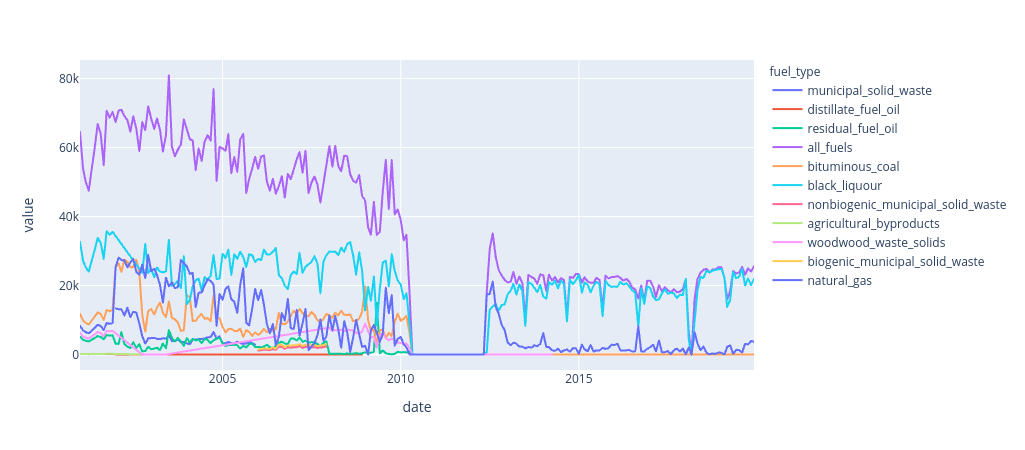

In [55]:
fig = px.line(
    plant_test_df.toPandas(), 
    x="date", 
    y="value", 
    color="fuel_type",
    hover_data=["end"])
fig.show()

So, fuel usage type can vary significantly based on time.  It might be worthwhile to make separate attributes for each fuel type by averaged bins, say every five years.  This plant in particular appears to have either a gap in data or shut down for a period of time to undergo modifications.  We can see that many fuel types either decreased or ceased altogether after production starting showing up again.  Either way, this type of information could provide insight on some characteristics that change over time, possibly by shifts in the energy industry.  However, let's first perform a little cleansing and formatting to the dataframe so that it is ready for machine learning models.  Note, the grain will be one row per plant, with additional columns representing time lags for each fuel.

In [56]:
#Pivot data and create an 'other' column that captures the 
#difference between total and the sum of the fuel_type categories
fuel_types_l = electricity_df\
    .select("fuel_type")\
    .distinct()\
    .rdd.map(lambda x: x[0])\
    .collect()

electricity_pivoted_summary_df = electricity_df\
    .groupBy("date", "plant_id")\
    .pivot("fuel_type")\
    .agg(pysF.sum("value"))\
    .fillna(
        0, 
        subset=[i for i in fuel_types_l if i])\
    .drop("null")\
    .withColumn(
        "other",
        pysF.col("all_fuels") - sum(pysF.col(i) for i in fuel_types_l if i and i != "all_fuels"))

In [57]:
#Unpivot back to original format
electricity_formatted_df = MySpark.melt(
    df = electricity_pivoted_summary_df,
    id_vars = ["date", "plant_id"],
    value_vars = [i for i in fuel_types_l if i and i != "all_fuels"],
    var_name = 'fuel_type')

In [58]:
electricity_formatted_df.limit(20).toPandas()

,date,plant_id,fuel_type,value
0,2018-03-01,10,blast_furnace_gas,0.0
1,2018-03-01,10,other_biomass_liquids,0.0
2,2018-03-01,10,geothermal,0.0
3,2018-03-01,10,other_gas,0.0
4,2018-03-01,10,solar,0.0
5,2018-03-01,10,tirederived_fuels,0.0
6,2018-03-01,10,agricultural_byproducts,0.0
7,2018-03-01,10,nuclear,0.0
8,2018-03-01,10,jet_fuel,0.0
9,2018-03-01,10,synthetic_coal,0.0


In [59]:
from pyspark.sql.window import Window as pysW
generation_lag1_windowspec = pysW\
    .partitionBy("plant_id", "fuel_type")\
    .orderBy("year")\
    .rangeBetween(pysW.currentRow - 1, pysW.currentRow - 1)

generation_lag2_windowspec = pysW\
    .partitionBy("plant_id", "fuel_type")\
    .orderBy("year")\
    .rangeBetween(pysW.currentRow - 2, pysW.currentRow - 2)

generation_lag5_windowspec = pysW\
    .partitionBy("plant_id", "fuel_type")\
    .orderBy("year")\
    .rangeBetween(pysW.currentRow - 5, pysW.currentRow - 5)

generation_lag10_windowspec = pysW\
    .partitionBy("plant_id", "fuel_type")\
    .orderBy("year")\
    .rangeBetween(pysW.currentRow - 10, pysW.currentRow - 10)

In [63]:
electricity_ml_formatted_df = electricity_formatted_df\
    .withColumn(
        "year",
        pysF.year(pysF.col("date")))\
    .groupBy("plant_id", "year", "fuel_type")\
    .agg(pysF.sum(pysF.col("value")).alias("generation"))\
    .withColumn(
        "generation_1y",
        pysF.avg(pysF.col("generation")).over(generation_lag1_windowspec))\
    .withColumn(
        "generation_2y",
        pysF.avg(pysF.col("generation")).over(generation_lag2_windowspec))\
    .withColumn(
        "generation_5y",
        pysF.avg(pysF.col("generation")).over(generation_lag5_windowspec))\
    .withColumn(
        "generation_10y",
        pysF.avg(pysF.col("generation")).over(generation_lag10_windowspec))\
    .filter(
        pysF.col("year") == 2019)\
    .groupBy("plant_id")\
    .pivot('fuel_type')\
    .agg(
        pysF.sum(pysF.col("generation")).alias("generation"),
        pysF.sum(pysF.col("generation_1y")).alias("generation_1y"),
        pysF.sum(pysF.col("generation_2y")).alias("generation_2y"),
        pysF.sum(pysF.col("generation_5y")).alias("generation_5y"),
        pysF.sum(pysF.col("generation_10y")).alias("generation_10y"))\
    .fillna(0)

electricity_ml_formatted_df.cache()

DataFrame[plant_id: string, agricultural_byproducts_generation: double, agricultural_byproducts_generation_1y: double, agricultural_byproducts_generation_2y: double, agricultural_byproducts_generation_5y: double, agricultural_byproducts_generation_10y: double, batteries_or_other_use_of_electricity_as_an_energy_source_generation: double, batteries_or_other_use_of_electricity_as_an_energy_source_generation_1y: double, batteries_or_other_use_of_electricity_as_an_energy_source_generation_2y: double, batteries_or_other_use_of_electricity_as_an_energy_source_generation_5y: double, batteries_or_other_use_of_electricity_as_an_energy_source_generation_10y: double, biogenic_municipal_solid_waste_generation: double, biogenic_municipal_solid_waste_generation_1y: double, biogenic_municipal_solid_waste_generation_2y: double, biogenic_municipal_solid_waste_generation_5y: double, biogenic_municipal_solid_waste_generation_10y: double, bituminous_coal_generation: double, bituminous_coal_generation_1y: d

In [64]:
electricity_ml_formatted_df.limit(10).toPandas()

,plant_id,agricultural_byproducts_generation,agricultural_byproducts_generation_1y,agricultural_byproducts_generation_2y,agricultural_byproducts_generation_5y,agricultural_byproducts_generation_10y,batteries_or_other_use_of_electricity_as_an_energy_source_generation,batteries_or_other_use_of_electricity_as_an_energy_source_generation_1y,batteries_or_other_use_of_electricity_as_an_energy_source_generation_2y,batteries_or_other_use_of_electricity_as_an_energy_source_generation_5y,...,wood_waste_liquids_ex_black_liqour_generation,wood_waste_liquids_ex_black_liqour_generation_1y,wood_waste_liquids_ex_black_liqour_generation_2y,wood_waste_liquids_ex_black_liqour_generation_5y,wood_waste_liquids_ex_black_liqour_generation_10y,woodwood_waste_solids_generation,woodwood_waste_solids_generation_1y,woodwood_waste_solids_generation_2y,woodwood_waste_solids_generation_5y,woodwood_waste_solids_generation_10y
0,56525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,57483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,60053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,60132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,60351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,60822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,63702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
electricity_ml_formatted_df.limit(1).toPandas().columns.tolist()

['plant_id',
 'agricultural_byproducts_generation',
 'agricultural_byproducts_generation_1y',
 'agricultural_byproducts_generation_2y',
 'agricultural_byproducts_generation_5y',
 'agricultural_byproducts_generation_10y',
 'batteries_or_other_use_of_electricity_as_an_energy_source_generation',
 'batteries_or_other_use_of_electricity_as_an_energy_source_generation_1y',
 'batteries_or_other_use_of_electricity_as_an_energy_source_generation_2y',
 'batteries_or_other_use_of_electricity_as_an_energy_source_generation_5y',
 'batteries_or_other_use_of_electricity_as_an_energy_source_generation_10y',
 'biogenic_municipal_solid_waste_generation',
 'biogenic_municipal_solid_waste_generation_1y',
 'biogenic_municipal_solid_waste_generation_2y',
 'biogenic_municipal_solid_waste_generation_5y',
 'biogenic_municipal_solid_waste_generation_10y',
 'bituminous_coal_generation',
 'bituminous_coal_generation_1y',
 'bituminous_coal_generation_2y',
 'bituminous_coal_generation_5y',
 'bituminous_coal_generat

### data transformation ideas
Convert grain to one row per plant, but need to express generation in some way
- Note, the grain on the current data is one row per plant per fuel type per month (if all_primemovers is removed)
- Maybe just do all metrics then pivot on fuel type for one col per fuel_type
- last 5 year by fuel type
- 5 year avg 5 years ago fuel type
- above metrics but expressed in terms of % of current value
- lag 
- lag by % of current value
- % fuel type?  are there mixed fuel plants?
- is grouping by fuel type necessary? again, are there mixed fuel types?
- start date? is that when the plant was operational?  maybe also cut off at end date if that is the case.
- max/min in terms of standardized generation (mean over same interval)
- Put full analysis in a .py file for transformation from raw to prepped dataframe for ML.